<H1> Hello World!!! </H1>

<H2> Tasks - </H2>
<br>
- Read all text files <br>
- Convert into single csv <br>
- Upload to bigQuery Google <br>
- Visualizations with Tableau <br>
- Run unsupervised clustering <br>
- Deliver actual results <br>
<br>
- 1 Folder to be trained and tested other 5 to be predicted with yes, maybe and no. <br>
- There are missing data Nan try remove and predict

In [1]:
import pandas as pd
import numpy as np
import os
import re
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
#Read text files

OneFile = "GPS Test Data/LI5-1834230M/PASS/2018_03_08_GEDE-XTJ-53W.txt"

with open(OneFile) as f:
    print(f.read())

2018-03-08 19:40:56	Input SN : GEDE-XTJ-53W





GPS Module Detect....


Detect OK! Use time = 6031.637 sec.






Enable GPS Module....


at@gpsengine=1



OK

*********************

Enable GPS Module OK! Use time = 3.550 sec.






GPS Signal Test....


TTFF = 112.0 (s)



SNR1 = 34

SNR2 = 34

SNR3 = 34

SNR4 = 34

SNR5 = 38

SNR6 = 37

SNR7 = 30

SNR8 = 38

*********************

GPS Signal Test PASS! Use time = 121.054 sec.


Total Time 00:02:41



In [3]:
content = []
with open(OneFile) as f:
    content = f.readlines()
    content = [x.strip() for x in content] 
    content = [elem for elem in content if elem != ""]
    print(content) 

['2018-03-08 19:40:56\tInput SN : GEDE-XTJ-53W', '===============', 'GPS Module Detect....', '===============', 'Detect OK! Use time = 6031.637 sec.', '===============', 'Enable GPS Module....', '===============', 'at@gpsengine=1', 'OK', '*********************', 'Enable GPS Module OK! Use time = 3.550 sec.', '===============', 'GPS Signal Test....', '===============', 'TTFF = 112.0 (s)', 'SNR1 = 34', 'SNR2 = 34', 'SNR3 = 34', 'SNR4 = 34', 'SNR5 = 38', 'SNR6 = 37', 'SNR7 = 30', 'SNR8 = 38', '*********************', 'GPS Signal Test PASS! Use time = 121.054 sec.', 'Total Time 00:02:41']


In [4]:
def return_text_list(fname):
    content = []
    
    with open(fname) as f:
        content = f.readlines()
        content = [x.strip() for x in content] 
        content = [elem for elem in content if elem != ""]
        
    return content

In [5]:
def more_cleaning(folder_name,content):
    tmp_content = {}
    
    #Adding folder name
    tmp_content['Folder'] = folder_name
    
    #Extracting DateTime
    dT = content[0].split("\t")[0]
    
    #Should convert to datetime
    tmp_content['DateTime'] = dT
    
    #Extracting Input SN
    tmp_str = content[0].split("\t")[1]
    SN = tmp_str[tmp_str.find(":")+2:]
    
    tmp_content['SN'] = SN
    
    #Extracting other features
    for each in content:
        matchObj = re.match('^[^\=]*\=[^\=]*$',each)

        if matchObj:
            tmp = each.split("=")
            tmp_content[tmp[0].strip()] = tmp[1].strip()
        else:
            continue
    return tmp_content
    

In [6]:
#Read multiple files
base = "GPS Test Data/"

list_of_d = []
for folder_name in os.listdir(base):
    dir_name = base+folder_name+"/PASS/"
    
    for each2 in os.listdir(dir_name):
        tmp_content = return_text_list(dir_name+each2)
        
        row_dic = more_cleaning(folder_name,tmp_content)
        list_of_d.append(row_dic)
        

In [7]:
df = pd.DataFrame(list_of_d)
df.head()

,Folder,DateTime,SN,Detect OK! Use time,at@gpsengine,Enable GPS Module OK! Use time,TTFF,SNR1,SNR2,SNR3,SNR4,SNR5,SNR6,SNR7,SNR8,GPS Signal Test PASS! Use time
0,LI5-1834230M,2018-03-08 19:40:56,GEDE-XTJ-53W,6031.637 sec.,1,3.550 sec.,112.0 (s),34,34,34,34,38,37,30,38,121.054 sec.
1,LI5-1834230M,2018-03-08 20:25:17,GEPT-UCW-TUC,8847.955 sec.,1,0.610 sec.,70.0 (s),29,33,34,33,37,27,37,27,121.050 sec.
2,LI5-1834230M,2018-03-08 20:36:15,GES6-4KZ-C93,9578.204 sec.,1,3.580 sec.,28.0 (s),36,28,36,27,29,39,31,34,46.380 sec.
3,LI5-1834230M,2018-03-08 20:26:19,GES6-SZW-AFB,8755.451 sec.,1,0.610 sec.,120.0 (s),37,37,36,37,30,34,28,34,120.402 sec.
4,LI5-1834230M,2018-03-08 20:27:00,GETA-PDD-W8K,9029.102 sec.,1,0.610 sec.,41.0 (s),31,27,27,37,37,27,37,27,44.970 sec.


In [8]:
#Change type of data
df["SNR1"] = pd.to_numeric(df["SNR1"])
df["SNR2"] = pd.to_numeric(df["SNR2"])
df["SNR3"] = pd.to_numeric(df["SNR3"])
df["SNR4"] = pd.to_numeric(df["SNR4"])
df["SNR5"] = pd.to_numeric(df["SNR5"])
df["SNR6"] = pd.to_numeric(df["SNR6"])
df["SNR7"] = pd.to_numeric(df["SNR7"])
df["SNR8"] = pd.to_numeric(df["SNR8"])

df["at@gpsengine"] = pd.to_numeric(df["at@gpsengine"])

df['DateTime'] = pd.to_datetime(df['DateTime'])

df['TTFF'] = df['TTFF'].map(lambda x: x.rstrip(' (s)'))
df['Detect OK! Use time'] = df['Detect OK! Use time'].map(lambda x: x.rstrip(' sec.'))
df['Enable GPS Module OK! Use time'] = df['Enable GPS Module OK! Use time'].map(lambda x: x.rstrip(' sec.'))
df['GPS Signal Test PASS! Use time'] = df['GPS Signal Test PASS! Use time'].map(lambda x: x.rstrip(' sec.'))

df["TTFF"] = pd.to_numeric(df["TTFF"])
df["Detect OK! Use time"] = pd.to_numeric(df["Detect OK! Use time"])
df["Enable GPS Module OK! Use time"] = pd.to_numeric(df["Enable GPS Module OK! Use time"])
df["GPS Signal Test PASS! Use time"] = pd.to_numeric(df["GPS Signal Test PASS! Use time"])

#Dropping ALL nan
df = df.dropna()

#Rename column name
df = df.rename(columns={"Detect OK! Use time": "Detect OK Use time", "Enable GPS Module OK! Use time": "Enable GPS Module OK Use time", "GPS Signal Test PASS! Use time": "GPS Signal Test PASS Use time"})

In [9]:
#print(df.isna().sum())
df.head()

,Folder,DateTime,SN,Detect OK Use time,at@gpsengine,Enable GPS Module OK Use time,TTFF,SNR1,SNR2,SNR3,SNR4,SNR5,SNR6,SNR7,SNR8,GPS Signal Test PASS Use time
0,LI5-1834230M,2018-03-08 19:40:56,GEDE-XTJ-53W,6031.637,1,3.55,112.0,34.0,34.0,34.0,34.0,38.0,37.0,30.0,38.0,121.054
1,LI5-1834230M,2018-03-08 20:25:17,GEPT-UCW-TUC,8847.955,1,0.61,70.0,29.0,33.0,34.0,33.0,37.0,27.0,37.0,27.0,121.050
2,LI5-1834230M,2018-03-08 20:36:15,GES6-4KZ-C93,9578.204,1,3.58,28.0,36.0,28.0,36.0,27.0,29.0,39.0,31.0,34.0,46.380
3,LI5-1834230M,2018-03-08 20:26:19,GES6-SZW-AFB,8755.451,1,0.61,120.0,37.0,37.0,36.0,37.0,30.0,34.0,28.0,34.0,120.402
4,LI5-1834230M,2018-03-08 20:27:00,GETA-PDD-W8K,9029.102,1,0.61,41.0,31.0,27.0,27.0,37.0,37.0,27.0,37.0,27.0,44.970


In [10]:
df.shape

(1779, 16)

In [11]:
df_fin0 = df.copy()
df_fin = df.copy()

#Train-test copy
Filtered = (df_fin['Folder'] == 'LI5-1834411M')
df_fin = df_fin[Filtered]

#Predicting copy
Filtered = (df_fin0['Folder'] != 'LI5-1834411M')
df_test = df_fin0[Filtered]

In [12]:
#Need to add positive and negative laels from doc

# Defective Serial No - 
#GN6U-8EF-FZ9, GPZ2-4A8-M7D, GSYM-W78-JX8, G8FF-3AH-VYX, GRV2-47G-N3B, GBZT-SPM-42E, GK2U-998-B72, GRVJ-YHK-92D, G8Y3-TJ8-SA8, GG42-C6K-82K, G2G9-WKX-4AD, GVSH-4VS-KRM, GHVT-NK3-JFZ, GJR7-UNB-RAB, GEFH-Z25-ZWX 

tmp_dict = {'SN': ['GN6U-8EF-FZ9', 'GPZ2-4A8-M7D', 'GSYM-W78-JX8', 'G8FF-3AH-VYX', 'GRV2-47G-N3B', 'GBZT-SPM-42E', 'GK2U-998-B72', 'GRVJ-YHK-92D', 'G8Y3-TJ8-SA8', 'GG42-C6K-82K', 'G2G9-WKX-4AD', 'GVSH-4VS-KRM', 'GHVT-NK3-JFZ', 'GJR7-UNB-RAB', 'GEFH-Z25-ZWX'],
           'Defective': [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]}

df_out = pd.DataFrame.from_dict(tmp_dict)

df_fin = pd.merge(df_fin, df_out, on='SN', how='left')
df_fin['Defective'] = df_fin['Defective'].fillna(0)

print(df_fin['Defective'].value_counts())
df_fin.head()

0.0    519
1.0     11
Name: Defective, dtype: int64


,Folder,DateTime,SN,Detect OK Use time,at@gpsengine,Enable GPS Module OK Use time,TTFF,SNR1,SNR2,SNR3,SNR4,SNR5,SNR6,SNR7,SNR8,GPS Signal Test PASS Use time,Defective
0,LI5-1834411M,2018-04-03 23:21:51,G2PX-U7Y-HKE,6064.282,1,3.58,35.0,46.0,46.0,46.0,45.0,46.0,46.0,46.0,46.0,38.41,0.0
1,LI5-1834411M,2018-04-03 23:04:21,G44J-NWG-XFD,4856.797,1,3.57,38.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,40.0,40.99,0.0
2,LI5-1834411M,2018-04-03 23:52:35,G4C5-MVC-AHK,767.341,1,3.58,30.0,45.0,45.0,45.0,45.0,45.0,45.0,27.0,45.0,32.12,0.0
3,LI5-1834411M,2018-04-03 23:19:24,G4GC-EWN-B8D,5760.736,1,0.60,27.0,42.0,42.0,42.0,42.0,43.0,43.0,43.0,43.0,57.42,0.0
4,LI5-1834411M,2018-04-03 22:36:06,G4S8-TT9-ATC,3334.120,1,0.61,23.0,44.0,43.0,44.0,44.0,44.0,44.0,44.0,44.0,26.50,0.0


- GRVJ-YHK-92D is twice because it's 2 different entries which are defective that's why 1st list has 15 count and the merging has 16.

In [13]:
df_fin.to_csv('Output_csv2.csv',index=False)

Decision Tree Output on generated csv
![title](img/DecTreeVis2.png)

[Text(0.5, 0, 'Detect OK Use time'),
 Text(1.5, 0, 'at@gpsengine'),
 Text(2.5, 0, 'Enable GPS Module OK Use time'),
 Text(3.5, 0, 'TTFF'),
 Text(4.5, 0, 'SNR1'),
 Text(5.5, 0, 'SNR2'),
 Text(6.5, 0, 'SNR3'),
 Text(7.5, 0, 'SNR4'),
 Text(8.5, 0, 'SNR5'),
 Text(9.5, 0, 'SNR6'),
 Text(10.5, 0, 'SNR7'),
 Text(11.5, 0, 'SNR8'),
 Text(12.5, 0, 'GPS Signal Test PASS Use time'),
 Text(13.5, 0, 'Defective')]

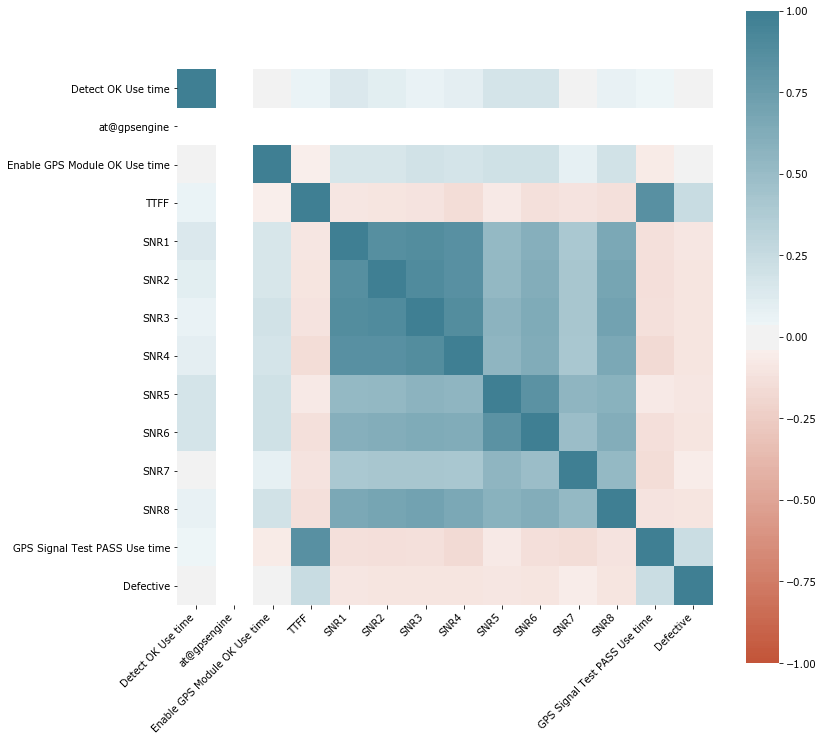

In [14]:
plt.figure(figsize=(12, 12))
corr = df_fin.corr(method="spearman")
ax = sns.heatmap(
corr, 
vmin=-1, vmax=1, center=0,
cmap=sns.diverging_palette(20, 220, n=200),
square=True
)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=45,
horizontalalignment='right'
)

In [15]:
corr = df_fin.corr(method="spearman")
corr.style.background_gradient(cmap="jet")

,Detect OK Use time,at@gpsengine,Enable GPS Module OK Use time,TTFF,SNR1,SNR2,SNR3,SNR4,SNR5,SNR6,SNR7,SNR8,GPS Signal Test PASS Use time,Defective
Detect OK Use time,1.000000,nan,-0.020541,0.060874,0.143328,0.105290,0.070032,0.092549,0.186883,0.181254,0.019961,0.076812,0.044966,-0.015700
at@gpsengine,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Enable GPS Module OK Use time,-0.020541,nan,1.000000,-0.045647,0.165728,0.168562,0.189032,0.186034,0.204152,0.200557,0.084608,0.192016,-0.067470,0.000360
TTFF,0.060874,nan,-0.045647,1.000000,-0.096803,-0.106629,-0.111381,-0.151696,-0.073728,-0.129507,-0.110269,-0.117431,0.851847,0.244126
SNR1,0.143328,nan,0.165728,-0.096803,1.000000,0.866064,0.881681,0.851026,0.524209,0.604622,0.399852,0.656989,-0.122161,-0.093622
SNR2,0.105290,nan,0.168562,-0.106629,0.866064,1.000000,0.898073,0.857551,0.537849,0.612647,0.422345,0.679707,-0.139710,-0.107757
SNR3,0.070032,nan,0.189032,-0.111381,0.881681,0.898073,1.000000,0.881675,0.570648,0.644668,0.424296,0.714994,-0.130516,-0.107745
SNR4,0.092549,nan,0.186034,-0.151696,0.851026,0.857551,0.881675,1.000000,0.549518,0.630024,0.415089,0.660135,-0.169428,-0.103044
SNR5,0.186883,nan,0.204152,-0.073728,0.524209,0.537849,0.570648,0.549518,1.000000,0.833419,0.549128,0.585489,-0.073806,-0.086739
SNR6,0.181254,nan,0.200557,-0.129507,0.604622,0.612647,0.644668,0.630024,0.833419,1.000000,0.485334,0.616724,-0.134615,-0.106802


In [16]:
#Train a J48 or similar model try to draw a graph of probability to identify regions where gps module start becoming defective.

#X_train = df_fin.iloc[:,:-1]
#Y_train = df_fin.iloc[:,-1]

#clf = tree.DecisionTreeClassifier()
#clf = clf.fit(X, Y)

In [17]:
def dec_tree_sk(df,col_name):
    i = df.columns.get_loc(col_name)
    df_Y_tem = df.iloc[:,i]
    df_X_tem = df.drop(col_name, axis = 'columns')
    
    clf = DecisionTreeClassifier()
    smote_pipeline = make_pipeline_imb(SMOTE(random_state = 4),clf)
    y_pred = smote_pipeline.fit(df_X_tem, df_Y_tem)
    return y_pred

In [18]:
def pred_func(y_pred_mod, test_df, col_name):

    tm_df = test_df.drop(col_name, axis = 'columns')
    y_pred_val = y_pred_mod.predict(tm_df)
    return y_pred_val

In [19]:
def pred_proba_func(y_pred_mod, test_df, col_name):

    tm_df = test_df.drop(col_name, axis = 'columns')
    y_pred_val = y_pred_mod.predict_proba(tm_df)
    return y_pred_val

In [20]:
def print_avg_metrics(k,avg_cm,avg_acc):
    print("Confusion Matrix - ")
    print(avg_cm/k)
    print("Accuracy")
    print(avg_acc*100/k)
    return ''

In [21]:
def conf_matrix(y_pred,y_actual):
        
    cm = confusion_matrix(y_actual, y_pred)
    acc = (y_actual == y_pred).sum()/len(y_actual)

    return cm,acc

In [22]:
#K in k-fold
k = 5
kf = KFold(n_splits=k)

df_fin = df_fin.drop(['Folder', 'at@gpsengine','DateTime','SN'], axis=1)

avg_cm = np.zeros([len(df_fin['Defective'].unique()),len(df_fin['Defective'].unique())])
avg_acc = 0

for train_index, test_index in kf.split(df_fin):
    tmp1_train,tmp1_test = df_fin.iloc[train_index,:], df_fin.iloc[test_index,:]
    
    print(" ")
    
    y_pred = dec_tree_sk(tmp1_train,'Defective')
    y_pred_val = pred_func(y_pred, tmp1_test, 'Defective')
    y_pred_proba_val = pred_proba_func(y_pred, tmp1_test, 'Defective')
    
    cm, acc = conf_matrix(y_pred_val,tmp1_test['Defective'])
    
    print_avg_metrics(1,cm,acc)

    avg_cm += cm
    avg_acc += acc
    
print_avg_metrics(k,avg_cm,avg_acc)

 
Confusion Matrix - 
[[104.   0.]
 [  1.   1.]]
Accuracy
99.05660377358491
 
Confusion Matrix - 
[[104.   0.]
 [  1.   1.]]
Accuracy
99.05660377358491
 
Confusion Matrix - 
[[102.   3.]
 [  0.   1.]]
Accuracy
97.16981132075472
 
Confusion Matrix - 
[[100.   1.]
 [  0.   5.]]
Accuracy
99.05660377358491
 
Confusion Matrix - 
[[105.   0.]
 [  0.   1.]]
Accuracy
100.0
Confusion Matrix - 
[[103.    0.8]
 [  0.4   1.8]]
Accuracy
98.86792452830188


''

In [23]:
df_fin

,Detect OK Use time,Enable GPS Module OK Use time,TTFF,SNR1,SNR2,SNR3,SNR4,SNR5,SNR6,SNR7,SNR8,GPS Signal Test PASS Use time,Defective
0,6064.282,3.58,35.0,46.0,46.0,46.0,45.0,46.0,46.0,46.0,46.0,38.41,0.0
1,4856.797,3.57,38.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,40.0,40.99,0.0
2,767.341,3.58,30.0,45.0,45.0,45.0,45.0,45.0,45.0,27.0,45.0,32.12,0.0
3,5760.736,0.60,27.0,42.0,42.0,42.0,42.0,43.0,43.0,43.0,43.0,57.42,0.0
4,3334.120,0.61,23.0,44.0,43.0,44.0,44.0,44.0,44.0,44.0,44.0,26.50,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,4504.336,3.57,33.0,47.0,47.0,48.0,47.0,47.0,48.0,48.0,47.0,34.96,0.0
526,8359.553,3.58,29.0,42.0,42.0,42.0,42.0,46.0,46.0,28.0,46.0,33.31,0.0
527,972.299,0.61,32.0,45.0,44.0,45.0,45.0,42.0,41.0,42.0,41.0,35.36,0.0
528,1902.943,3.58,29.0,46.0,46.0,46.0,46.0,28.0,45.0,27.0,45.0,32.13,0.0


In [24]:
df_test1 = df_test.drop(['Folder', 'at@gpsengine','DateTime','SN'], axis=1)

df_train, df_test = df_fin, df_test1

clf = clf = MLPClassifier(solver='adam', activation='logistic', alpha=1e-5,hidden_layer_sizes=(8, 5, 3), random_state=1)
smote_pipeline = make_pipeline_imb(SMOTE(random_state = 4),clf)
y_pred = smote_pipeline.fit(df_train.iloc[:,:-1], df_train.iloc[:,-1])

y_pred_val = y_pred.predict(df_test)
y_pred_val_proba = y_pred.predict_proba(df_test)

df_test['Defective_Pred'] = y_pred_val
df_test['Proba_0'] = y_pred_val_proba[:,0]
df_test['Proba_1'] = y_pred_val_proba[:,1]

In [25]:
df_test.to_csv('Out3.csv',index=False)